## Introduction
This notebook explores the use of clustering as data exploration for customer segmentation by analyzing usage behavior of about 9000 active credit card holders during a 6 month period. Typically there are models such as RFM model, LTV models, etc., to perform such task. Here the data is used as-is (with some scaling, etc.) to perform clustering.

The dataset taken from Kaggle as credit card dataset that can be found [here](https://www.kaggle.com/arjunbhasin2013/ccdata/data). The goal is to segment the customers into groups, to reveal (any) hidden pattern within the customers with no knowledge of labels.  
Three approaches implemented are Hierarchical method, Density based and Distribution model-based:
1. Hierarchical Clustering
2. DBScan
3. Gaussian Mixture Models

This dataset does not have label, hence it is an illustration of using unsupervised techniques. 
For each method, following approach is taken:
1. Perform clustering choosing between 3-5 clusters
2. Using the **original unscaled data** (without the customer ID), calculate the mean of each cluster
3. Analyse the results and findings

This is a very simple approach to customer segmentation assigning the customers into groups, and try to extract some common features from observations within the same group.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
# Load data
CC = pd.read_csv("creditcard.csv")
CC.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
CC.shape

(8950, 18)

First remove the CUST_ID column (since we want all numeric features). Then remove missing values and scale the data, since the features are on different scale. Save the scaled data as a different variable.

In [4]:
# Remove CUST_ID
del CC['CUST_ID']

# Remove missing values
CC.dropna(axis=0, inplace = True)

# Scale data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(CC)
X = scaler.transform(CC) #Save the scaled data as a different variable
X.shape

(8636, 17)

#### Diagnose correlation matrix for post clustering analysis

In [5]:
CC.corr()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
BALANCE,1.000000,0.310140,0.176083,0.159985,0.122109,0.495586,-0.088459,0.063832,-0.069582,0.445307,0.382388,0.147887,0.535518,0.322830,0.398669,-0.333594,0.066987
BALANCE_FREQUENCY,0.310140,1.000000,0.122635,0.095254,0.114739,0.089036,0.228158,0.187467,0.184159,0.181132,0.133265,0.183095,0.087682,0.039169,0.132519,-0.156961,0.104714
PURCHASES,0.176083,0.122635,1.000000,0.916780,0.679259,-0.053760,0.393000,0.497384,0.316025,-0.124863,-0.070277,0.688732,0.358425,0.606782,0.093842,0.176447,0.084545
ONEOFF_PURCHASES,0.159985,0.095254,0.916780,1.000000,0.329650,-0.033244,0.265460,0.524514,0.128380,-0.086413,-0.048705,0.545313,0.320613,0.570850,0.048741,0.129890,0.063400
INSTALLMENTS_PURCHASES,0.122109,0.114739,0.679259,0.329650,1.000000,-0.066099,0.441193,0.211829,0.511130,-0.136455,-0.076716,0.626083,0.258057,0.385391,0.132156,0.178440,0.083346
CASH_ADVANCE,0.495586,0.089036,-0.053760,-0.033244,-0.066099,1.000000,-0.218566,-0.090111,-0.178873,0.629030,0.656911,-0.078449,0.304161,0.459342,0.140094,-0.158566,-0.073090
PURCHASES_FREQUENCY,-0.088459,0.228158,0.393000,0.265460,0.441193,-0.218566,1.000000,0.502123,0.862338,-0.316771,-0.208749,0.567168,0.121372,0.100715,0.002979,0.305393,0.052161
ONEOFF_PURCHASES_FREQUENCY,0.063832,0.187467,0.497384,0.524514,0.211829,-0.090111,0.502123,1.000000,0.143911,-0.118225,-0.073384,0.544364,0.295432,0.244346,-0.030357,0.154073,0.080437
PURCHASES_INSTALLMENTS_FREQUENCY,-0.069582,0.184159,0.316025,0.128380,0.511130,-0.178873,0.862338,0.143911,1.000000,-0.268924,-0.172811,0.529192,0.063421,0.083424,0.030036,0.249547,0.065779
CASH_ADVANCE_FREQUENCY,0.445307,0.181132,-0.124863,-0.086413,-0.136455,0.629030,-0.316771,-0.118225,-0.268924,1.000000,0.799593,-0.136913,0.132841,0.182340,0.098844,-0.260001,-0.140038


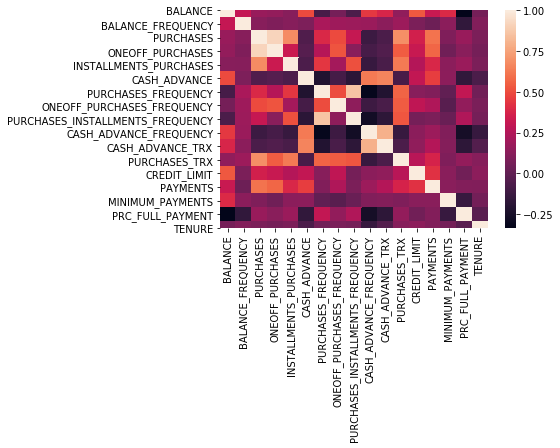

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(CC.corr())

**Observation:**  
From the correlation matrix we can observe that:   
    1. PURCHASES has a high correlation with ONEOFF_PURCHASES  
    2. PURCHASES_FREQUENCY has a high correlation with PURCHASES_INSTALLMENTS_FREQUENCY  
    3. CASH_ADVANCE_FREQUENCY has a high correlation with CASH_ADVANCE_TRX  
Therefore, we will use one of these respectively for our findings and comparisons for segmentation analysis post clustering.
    

### 1. Hierarchical Clustering
It is a hierarchical representation in which clusters of next level are created by merging (or splitting) clusters at current level. It could be Agglomerative (bottom-up) or divisive (top-down).
One can visually inspect the result using a dendrogram.

In Agglomerative clustering all observations are initialized as its own cluster and the idea is to recursively merge clusters until only 1 cluster is remaining, i.e. all observations belong to the same cluster.

**Approach:**
    1. Produce hierarchical clusters by merging and visually inspect the result using a dendrogram.
    2. Run Agglomerative Clustering for relevant number of clusters (given to be between 3 to 5).
    3. Evaluate using silhouette score method for choice of K.
    4. Perform Agglomerative Clustering with best K and assign labels.
    5. Extract observations from the original unscaled data (without the customer ID), to calculate the mean of each cluster made.

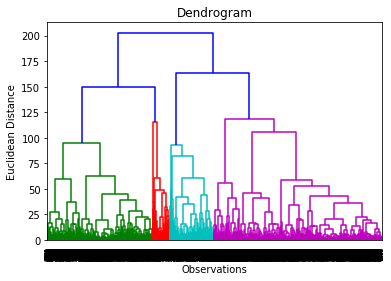

In [8]:
# Step 1. hierarchical clustering with dendogram inspection

import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Euclidean Distance')
plt.show()

To determine number of clusters, draw a horizontal line across the dendogram at some height typically trying to at least intersect the longest vertical line.  

From the graph above it seems blue line is longest and the threshold can be at 125 and as a result, k = 4 might be a good choice. Below is a graph with the threshold line. 

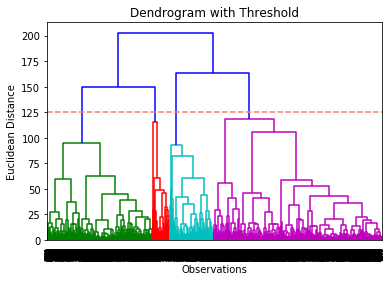

In [9]:
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.axhline(y=125, color='salmon', linestyle='--')
plt.title('Dendrogram with Threshold')
plt.xlabel('Observations')
plt.ylabel('Euclidean Distance')
plt.show()

We are going with a range from 3 to 5 clusters. To determine if 4 is a good choice or not let's evaluate with the silhoutte scores method(more the better) and find best k(no. of clusters).Silhoutte scores measures how similar an observation is to its own cluster compared to other clusters.

In [10]:
# Step 2. Agglomerative Clustering for various number of clusters.

from sklearn.cluster import AgglomerativeClustering
AC_per_k = [AgglomerativeClustering(n_clusters=k).fit(X)
                for k in range(3, 6)]

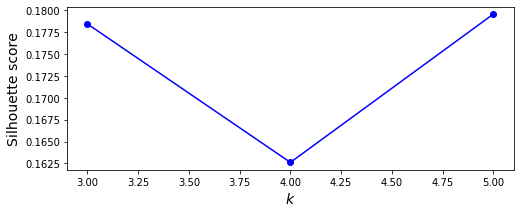

In [11]:
# Step 3 . Evalutaion of best K using silhouette score for K between 3-5

from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in AC_per_k[:]]

plt.figure(figsize=(8, 3))
plt.plot(range(3, 6), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [12]:
k = list(range(3,6))
best_k = k[np.argmax(silhouette_scores)]
print("best k:",best_k)

best k: 5


Based on silhoutte score 5 is the best, but score of k =3 and k =5 are quite close, so 3 seems good too. For the ease of comparison amongst cluster types, let's go with 3 and compare the cluster features.

In [13]:
# Step 4. Agglomerative Clustering with k = 5 and assign labels
AC = AgglomerativeClustering(n_clusters = best_k)
AC.fit_predict(X)
AC.labels_

array([1, 2, 3, ..., 4, 4, 4], dtype=int64)

In [14]:
# Step 5. Extract mean of corresponding unscaled data based on clusters formed

CC_analysis = CC.copy() # unscaled data without customer ID
CC_analysis['Cluster'] = AC.labels_ # Add the labels to observations
df_hs = CC_analysis.groupby('Cluster').mean() #Group by labels and extract the corresponding observations' mean values 
df_hs

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
Cluster,,,,,,,,,,,,,,,,,
0,3879.514557,0.988517,6908.217849,4581.572037,2328.018810,679.151156,0.950319,0.720803,0.807517,0.078805,1.940503,84.908467,9467.048055,6344.149755,1794.436496,0.158697,11.965675
1,951.682904,0.809199,304.735132,192.578754,112.549719,527.441409,0.219492,0.081253,0.137013,0.103220,2.074175,3.950095,3304.832770,982.955316,669.163320,0.097254,11.840196
2,4695.246244,0.976833,516.485713,333.451417,183.144519,4167.246654,0.259272,0.141404,0.161969,0.442056,13.413547,7.625668,7805.748663,3759.561600,2217.096414,0.037234,11.795009
3,954.735370,0.975482,1385.719044,709.145632,676.753047,286.676850,0.893277,0.333145,0.700948,0.050301,1.007689,23.716221,4430.276955,1577.517889,539.832131,0.283814,11.939216
4,1130.427868,0.839706,523.411384,301.599912,221.855655,1319.908528,0.490202,0.142575,0.344338,0.209196,3.480118,7.234168,2856.730486,747.323725,389.224031,0.195720,7.546392


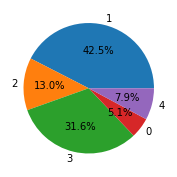

In [15]:
# Pie chart to see cluster size

a= list(AC.labels_) # list of labels
from collections import Counter
c=Counter(a)
cluster_count= list(c.values()) # Cluster count
cluster_labels= list(c.keys()) # Cluster Labels

fig = plt.figure(figsize =(5, 3)) 
plt.pie(cluster_count, labels = cluster_labels, autopct='%.1f%%') 
plt.show()


### Findings

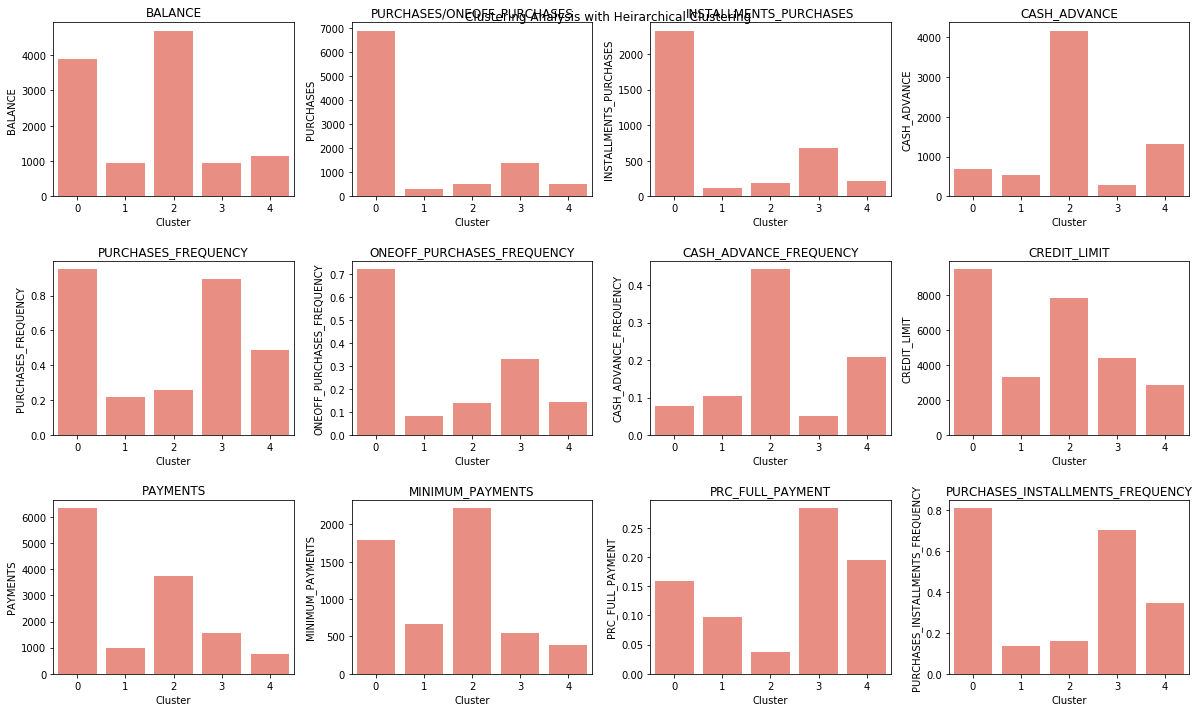

In [16]:
# Plot cluster-wise means of features for comparison

fig1, axes = plt.subplots(3, 4, figsize=(17, 10))

# PLot features
# Balance
sns.barplot(ax=axes[0,0], x=df_hs.index, y=df_hs['BALANCE'],color='salmon' )
axes[0,0].set_title('BALANCE')

# Purchases
sns.barplot(ax=axes[0,1], x=df_hs.index, y=df_hs['PURCHASES'],color='salmon' )
axes[0,1].set_title('PURCHASES/ONEOFF_PURCHASES')

# INSTALLMENTS_PURCHASES
sns.barplot(ax=axes[0,2], x=df_hs.index, y=df_hs['INSTALLMENTS_PURCHASES'],color='salmon' )
axes[0,2].set_title('INSTALLMENTS_PURCHASES')

# CASH_ADVANCE
sns.barplot(ax=axes[0,3], x=df_hs.index, y=df_hs['CASH_ADVANCE'],color='salmon' )
axes[0,3].set_title('CASH_ADVANCE')

# PURCHASES_FREQUENCY
sns.barplot(ax=axes[1,0], x=df_hs.index, y=df_hs['PURCHASES_FREQUENCY'],color='salmon' )
axes[1,0].set_title('PURCHASES_FREQUENCY')

# ONEOFF_PURCHASES_FREQUENCY
sns.barplot(ax=axes[1,1], x=df_hs.index, y=df_hs['ONEOFF_PURCHASES_FREQUENCY'],color='salmon' )
axes[1,1].set_title('ONEOFF_PURCHASES_FREQUENCY')

# CASH_ADVANCE_FREQUENCY
sns.barplot(ax=axes[1,2], x=df_hs.index, y=df_hs['CASH_ADVANCE_FREQUENCY'],color='salmon' )
axes[1,2].set_title('CASH_ADVANCE_FREQUENCY')

# CREDIT_LIMIT
sns.barplot(ax=axes[1,3], x=df_hs.index, y=df_hs['CREDIT_LIMIT'],color='salmon' )
axes[1,3].set_title('CREDIT_LIMIT')

# PAYMENTS
sns.barplot(ax=axes[2,0], x=df_hs.index, y=df_hs['PAYMENTS'],color='salmon' )
axes[2,0].set_title('PAYMENTS')

# MINIMUM_PAYMENTS
sns.barplot(ax=axes[2,1], x=df_hs.index, y=df_hs['MINIMUM_PAYMENTS'],color='salmon' )
axes[2,1].set_title('MINIMUM_PAYMENTS')

# PRC_FULL_PAYMENT
sns.barplot(ax=axes[2,2], x=df_hs.index, y=df_hs['PRC_FULL_PAYMENT'],color='salmon' )
axes[2,2].set_title('PRC_FULL_PAYMENT')

# PURCHASES_INSTALLMENTS_FREQUENCY
sns.barplot(ax=axes[2,3], x=df_hs.index, y=df_hs['PURCHASES_INSTALLMENTS_FREQUENCY'],color='salmon' )
axes[2,3].set_title('PURCHASES_INSTALLMENTS_FREQUENCY')

fig1.suptitle('Clustering Analysis with Heirarchical Clustering')
plt.tight_layout()

**Observations:**   
**Cluster 0:** Smallest group/cluster (5.1%) that are Biggest spenders as they have biggest purchases with highest Credit Limit and Payments. Additionally, they have good Balance and fairly good Percentage of Full Payment but low Cash Advances. These customers can be targeted to spend more by raising their credit limit even further. 

**Cluster 1:** Small spenders.This is biggest cluster (42.5%) showing lowest Balance, lowest Purchases, low credit limit and low Payments. These seem to be frugal.  

**Cluster 2:** Could be called Revolvers (One who uses the card and carries a balance over from one month to the next, incurring interest charges) The graph shows they are a fairly small group(13%) and they have highest Balance and Cash Advance. They also have one of the lowest Purchase Frequency and Percentage of Full Payment. They are one of the most lucrative segments for the credit card provider.

**Cluster 3:** Could be called Transactors. As evident from pie chart, they are fairly big group/cluster(31.6%) with lowest Balance and Cash Advance.They have highest Percentage of Full Payment. So they pay off their balance regularly and therefore pay little or no interest charges.   

**Cluster 4:** Medium Purchase Frequency with low Puchases aand Payments but highest Percentage of Full Payment with lowest Credit Limit. In addition, their Tenure is also the lowest so they could be new customers who could be targeted to increase their activity through offers. They are the second lowest grouo/cluster(7.9%).


### 2. DBScan
DBScan is Density-based spatial clustering of applications with noise (outliers).  
K-means tries to form clusters in circles but it is not good if data has arbitrary shape. Therefore, some density / manifold based methods are more appropriate. DBScan is good at separating clusters of high vs low density. It works on the basic idea that a point belongs to a cluster if it is close to many points from that cluster.


**Approach:**
    1. Produce appropriate K (between to 3-5 clusters) with DBScan by trying different combinations of epsilon and min_samples.
    2. Find uniques clusters and choose a K. Also, consider outliers as one cluster. Assign labels
    3. Extract observations from the original unscaled data (without the customer ID), to calculate the mean of each cluster made.

Try different combinations of epsilon and min_samples to get to the appropriate number of clusters.  
Also, np.unique() is used to help locate the unique number of clusters.  
We will consider outliers as one cluster as well.  


In [18]:
# Step 1 & 2. DBScan to make clusters between 3-5, choose one K and assign labels.

# Try different combinations of epsilon and min_samples to get clusters between 3 to 5
# Note: Prefer small epsilon and min samples >= Dimension(Data) + 1


from sklearn.cluster import DBSCAN

dbscan1 = DBSCAN(eps = 0.06,min_samples =  7) # The default epsilon is 0.5 and min_samples is 5
dbscan1.fit_predict(X)
print(np.unique(dbscan1.labels_))

dbscan2 = DBSCAN(eps = 0.09,min_samples = 6) 
dbscan2.fit_predict(X)
print(np.unique(dbscan2.labels_))

dbscan3 = DBSCAN(eps = 0.17, min_samples = 10) 
dbscan3.fit_predict(X)
print(np.unique(dbscan3.labels_))

dbscan4 = DBSCAN(eps = 0.2, min_samples = 15)
dbscan4.fit_predict(X)
print(np.unique(dbscan4.labels_))

[-1  0  1  2]
[-1  0  1  2  3]
[-1  0  1  2  3]
[-1  0  1  2  3]


In [19]:
# Step 3. Extract mean of corresponding unscaled data based on clusters formed

# Chose dbscan3 with relatively low epsilon and min samples. Can perform evaluation to choose the best cluster. 

CC_analysis_DBS = CC.copy() # unscaled data without customer ID
CC_analysis_DBS['Cluster'] = dbscan3.labels_ # Add the labels to observations
df_dbs= CC_analysis_DBS.groupby('Cluster').mean() #Group by labels and extract the corresponding observations' mean values 
df_dbs

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
Cluster,,,,,,,,,,,,,,,,,
-1,1607.936965,0.892889,1046.164985,617.036057,429.446384,1011.968182,0.505903,0.209882,0.37636,0.138221,3.352475,15.337351,4584.760502,1813.281015,873.378014,0.16256,11.524873
0,1293.692240,1.000000,0.000000,0.000000,0.000000,133.173900,0.000000,0.000000,0.00000,0.083333,1.113636,0.000000,1477.840909,377.249323,414.545893,0.00000,12.000000
1,1323.170846,1.000000,0.000000,0.000000,0.000000,161.715955,0.000000,0.000000,0.00000,0.166667,2.250000,0.000000,1466.666667,389.610806,434.856072,0.00000,12.000000
2,1081.411641,1.000000,81.361250,81.361250,0.000000,0.000000,0.083333,0.083333,0.00000,0.000000,0.000000,1.125000,1379.166667,340.450753,399.721263,0.00000,12.000000
3,1299.741844,1.000000,0.000000,0.000000,0.000000,148.570869,0.000000,0.000000,0.00000,0.250000,3.153846,0.000000,1415.384615,375.812445,445.608551,0.00000,12.000000


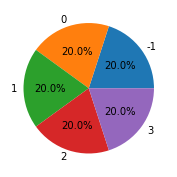

In [20]:
# Pie chart to see cluster size

a= np.unique(dbscan3.labels_) # list of labels

c=Counter(a)
cluster_count= list(c.values()) # Cluster count
cluster_labels= list(c.keys()) # Cluster Labels

fig = plt.figure(figsize =(5, 3)) 
plt.pie(cluster_count, labels = cluster_labels, autopct='%.1f%%') 
plt.show()


### Findings

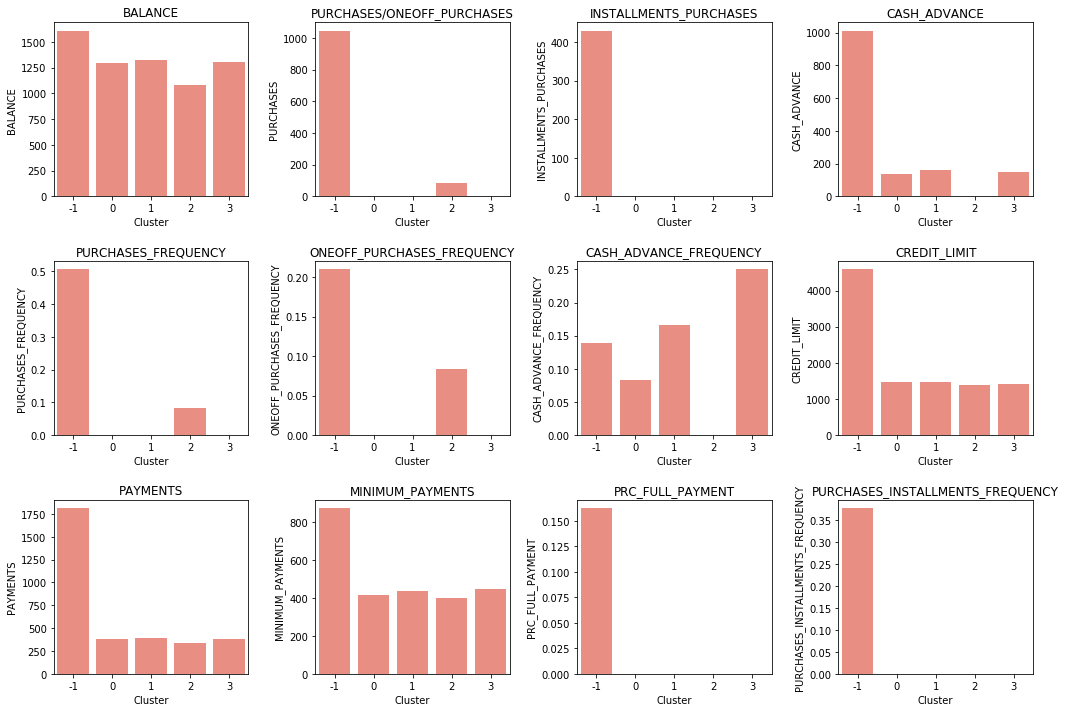

In [21]:
fig2, axes = plt.subplots(3, 4, figsize=(15, 10))
#fig2.suptitle('Clustering Analysis with DBScan')

# Balance
sns.barplot(ax=axes[0,0], x=df_dbs.index, y=df_dbs['BALANCE'],color='salmon' )
axes[0,0].set_title('BALANCE')

# Purchases
sns.barplot(ax=axes[0,1], x=df_dbs.index, y=df_dbs['PURCHASES'],color='salmon' )
axes[0,1].set_title('PURCHASES/ONEOFF_PURCHASES')

# INSTALLMENTS_PURCHASES
sns.barplot(ax=axes[0,2], x=df_dbs.index, y=df_dbs['INSTALLMENTS_PURCHASES'],color='salmon' )
axes[0,2].set_title('INSTALLMENTS_PURCHASES')

# CASH_ADVANCE
sns.barplot(ax=axes[0,3], x=df_dbs.index, y=df_dbs['CASH_ADVANCE'],color='salmon' )
axes[0,3].set_title('CASH_ADVANCE')

# PURCHASES_FREQUENCY
sns.barplot(ax=axes[1,0], x=df_dbs.index, y=df_dbs['PURCHASES_FREQUENCY'],color='salmon' )
axes[1,0].set_title('PURCHASES_FREQUENCY')

# ONEOFF_PURCHASES_FREQUENCY
sns.barplot(ax=axes[1,1], x=df_dbs.index, y=df_dbs['ONEOFF_PURCHASES_FREQUENCY'],color='salmon' )
axes[1,1].set_title('ONEOFF_PURCHASES_FREQUENCY')

# CASH_ADVANCE_FREQUENCY
sns.barplot(ax=axes[1,2], x=df_dbs.index, y=df_dbs['CASH_ADVANCE_FREQUENCY'],color='salmon' )
axes[1,2].set_title('CASH_ADVANCE_FREQUENCY')

# CREDIT_LIMIT
sns.barplot(ax=axes[1,3], x=df_dbs.index, y=df_dbs['CREDIT_LIMIT'],color='salmon' )
axes[1,3].set_title('CREDIT_LIMIT')

# PAYMENTS
sns.barplot(ax=axes[2,0], x=df_dbs.index, y=df_dbs['PAYMENTS'],color='salmon' )
axes[2,0].set_title('PAYMENTS')

# MINIMUM_PAYMENTS
sns.barplot(ax=axes[2,1], x=df_dbs.index, y=df_dbs['MINIMUM_PAYMENTS'],color='salmon' )
axes[2,1].set_title('MINIMUM_PAYMENTS')

# PRC_FULL_PAYMENT
sns.barplot(ax=axes[2,2], x=df_dbs.index, y=df_dbs['PRC_FULL_PAYMENT'],color='salmon' )
axes[2,2].set_title('PRC_FULL_PAYMENT')

# PURCHASES_INSTALLMENTS_FREQUENCY
sns.barplot(ax=axes[2,3], x=df_dbs.index, y=df_dbs['PURCHASES_INSTALLMENTS_FREQUENCY'],color='salmon' )
axes[2,3].set_title('PURCHASES_INSTALLMENTS_FREQUENCY')

plt.tight_layout()

**Observations:** Cluster group equally divided across the dataset. Clustering does not seem too well because outlier cluster (-1) has most highest features and rest of the clusters have fairly similar features.

**Cluster 0:** Fairly high Balance and frugal as they do not make any Purchases. Give low Cash Advance and have a low credit limit.

**Cluster 1:** Non spenders with higher frequency of paying advance cash than cluster 0. Rest are same or similar features as Cluster 0.  

**Cluster 2:** Very low spenders with some Oneoff purchase frequency but lowest Balance and no Cash Advance. They have low amount of Purchases and not much frequent. Rest of the features are similar to Cluster 0 and 1

**Cluster 3:** Highest Cash Advance Frequency with rest of the features same/similar to Cluster 0 and 1.

**Cluster -1:** Highest Balance with most expensive and frequent Purchases. They pay most Cash in Advance having highest Credit Limit and Percentage of Full Payment.

### 3. Gaussian Mixture Models GMM
GMM is a probabilistic model that assumes observations are generated from a mixture of several Gaussian distributions (of unknown parameters). All instances generated from a single Gaussian distribution form a cluster that typically looks like an ellipsoid.Both hard clustering or soft clustering can be done using GMM. It is similar to K-means as one needs to prespecify the number of mixtures (i.e. number of clusters).  
Selection of K is done using model selection criterion, such as AIC or BIC.

**Approach:**
    1. Prespecify number of mixtures(clusters) with GMM.
    2. Select K using model selection criterion, such as AIC or BIC.
    3. Assign labels
    4. Extract observations from the original unscaled data (without the customer ID), to calculate the mean of each cluster made.

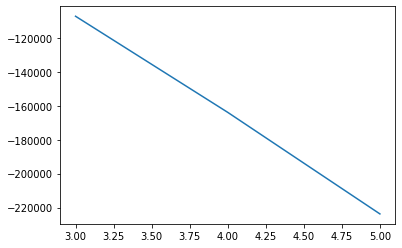

In [23]:
# Step 1 & 2. Prespecify number of mixtures(clusters) with GMM and evaluate best K using AIC.

from sklearn.mixture import GaussianMixture

n_components = [3,4,5] # Number of clusters
models = [GaussianMixture(n, n_init=10, random_state=42)
          for n in n_components]

# fit and find score
aics = [model.fit(X).aic(X) for model in models]
plt.plot(n_components, aics);

In [24]:
k = list(range(3,6))
best_K = k[np.argmin(aics)]
print("Best K is {} with least AIC of : {}".format(best_K,min(aics).round(3)))

Best K is 5 with least AIC of : -223777.278


In [25]:
# Step 3. Assign labels according to best K evaluated

best_model = models[np.argmin(aics)]
best_model.fit(X)
labels = best_model.predict(X)
print(labels)
print("Unique cluster labels are:", np.unique(labels))

[0 1 4 ... 0 1 2]
Unique cluster labels are: [0 1 2 3 4]


In [26]:
# Step 4. Extract mean of corresponding unscaled data based on clusters formed

CC_analysis_GMM = CC.copy() # unscaled data without customer ID
CC_analysis_GMM['Cluster'] = labels # Add the labels to observations
df_gmm = CC_analysis_GMM.groupby('Cluster').mean() #Group by labels and extract the corresponding observations' mean values
df_gmm

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
Cluster,,,,,,,,,,,,,,,,,
0,202.384380,0.802485,1013.284860,536.659897,476.634937,0.000000,0.672996,0.236017,0.515262,0.000000,0.000000,15.892620,4173.645548,1089.204506,159.319673,0.358912,11.514960
1,2174.605161,0.900964,0.000000,0.000000,0.000000,1980.209657,0.000000,0.000000,0.000000,0.276614,6.152507,0.000000,4042.304310,1657.335749,711.289655,0.045931,11.345119
2,1673.480266,0.884972,833.660785,539.680663,293.980122,2414.699945,0.519373,0.232301,0.334541,0.281818,8.180428,11.838940,4349.169884,2835.959462,790.848834,0.116393,10.680938
3,3098.172281,0.970774,5926.298963,3792.277259,2140.477037,1138.146133,0.792786,0.461276,0.666350,0.113876,3.338272,66.528395,7613.456790,6965.240662,5298.097650,0.234362,11.933333
4,2642.558698,1.000000,1103.414474,658.013136,445.419327,853.614268,0.608649,0.278476,0.441912,0.145540,3.230933,18.518960,4894.887090,1444.727638,1156.990950,0.000000,12.000000


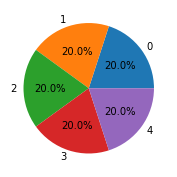

In [27]:
# Pie chart to see cluster size

a= np.unique(labels) # list of labels

c=Counter(a)
cluster_count= list(c.values()) # Cluster count
cluster_labels= list(c.keys()) # Cluster Labels

fig = plt.figure(figsize =(5, 3)) 
plt.pie(cluster_count, labels = cluster_labels, autopct='%.1f%%') 
plt.show()

### Findings

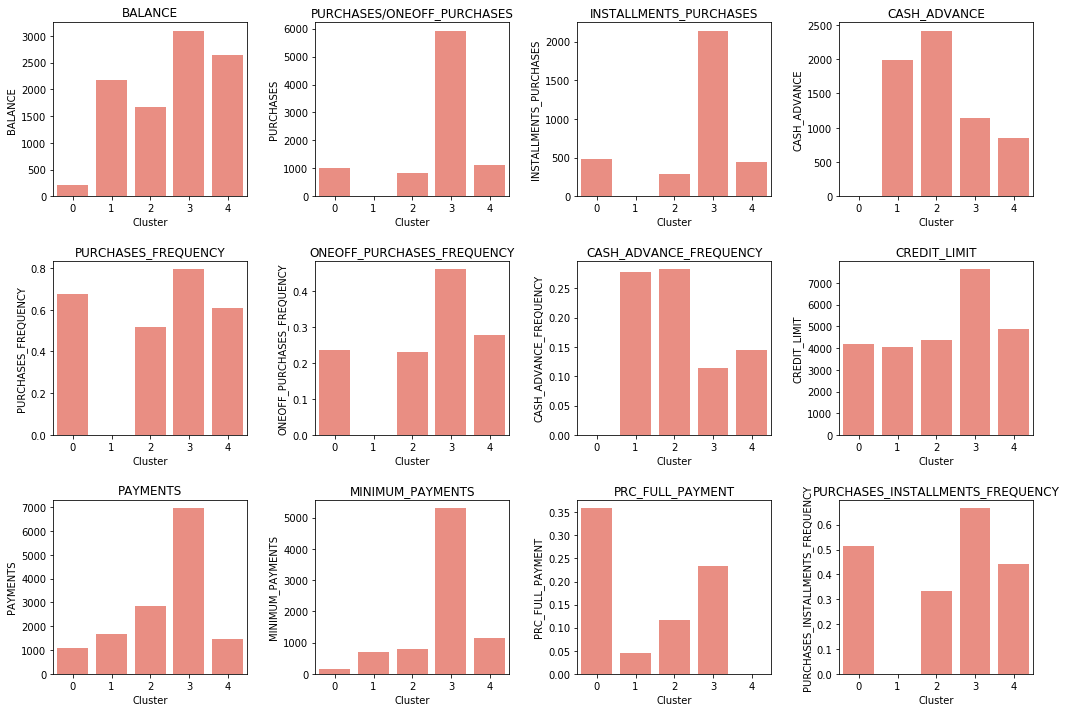

In [28]:
fig3, axes = plt.subplots(3, 4, figsize=(15, 10))
#fig3.suptitle('Clustering Analysis with GMM')

# Balance
sns.barplot(ax=axes[0,0], x=df_gmm.index, y=df_gmm['BALANCE'],color='salmon' )
axes[0,0].set_title('BALANCE')

# Purchases
sns.barplot(ax=axes[0,1], x=df_gmm.index, y=df_gmm['PURCHASES'],color='salmon' )
axes[0,1].set_title('PURCHASES/ONEOFF_PURCHASES')

# INSTALLMENTS_PURCHASES
sns.barplot(ax=axes[0,2], x=df_gmm.index, y=df_gmm['INSTALLMENTS_PURCHASES'],color='salmon' )
axes[0,2].set_title('INSTALLMENTS_PURCHASES')

# CASH_ADVANCE
sns.barplot(ax=axes[0,3], x=df_gmm.index, y=df_gmm['CASH_ADVANCE'],color='salmon' )
axes[0,3].set_title('CASH_ADVANCE')

# PURCHASES_FREQUENCY
sns.barplot(ax=axes[1,0], x=df_gmm.index, y=df_gmm['PURCHASES_FREQUENCY'],color='salmon' )
axes[1,0].set_title('PURCHASES_FREQUENCY')

# ONEOFF_PURCHASES_FREQUENCY
sns.barplot(ax=axes[1,1], x=df_gmm.index, y=df_gmm['ONEOFF_PURCHASES_FREQUENCY'],color='salmon' )
axes[1,1].set_title('ONEOFF_PURCHASES_FREQUENCY')

# CASH_ADVANCE_FREQUENCY
sns.barplot(ax=axes[1,2], x=df_gmm.index, y=df_gmm['CASH_ADVANCE_FREQUENCY'],color='salmon' )
axes[1,2].set_title('CASH_ADVANCE_FREQUENCY')

# CREDIT_LIMIT
sns.barplot(ax=axes[1,3], x=df_gmm.index, y=df_gmm['CREDIT_LIMIT'],color='salmon' )
axes[1,3].set_title('CREDIT_LIMIT')

# PAYMENTS
sns.barplot(ax=axes[2,0], x=df_gmm.index, y=df_gmm['PAYMENTS'],color='salmon' )
axes[2,0].set_title('PAYMENTS')

# MINIMUM_PAYMENTS
sns.barplot(ax=axes[2,1], x=df_gmm.index, y=df_gmm['MINIMUM_PAYMENTS'],color='salmon' )
axes[2,1].set_title('MINIMUM_PAYMENTS')

# PRC_FULL_PAYMENT
sns.barplot(ax=axes[2,2], x=df_gmm.index, y=df_gmm['PRC_FULL_PAYMENT'],color='salmon' )
axes[2,2].set_title('PRC_FULL_PAYMENT')

# PURCHASES_INSTALLMENTS_FREQUENCY
sns.barplot(ax=axes[2,3], x=df_gmm.index, y=df_gmm['PURCHASES_INSTALLMENTS_FREQUENCY'],color='salmon' )
axes[2,3].set_title('PURCHASES_INSTALLMENTS_FREQUENCY')

plt.tight_layout()

**Observations:** 
Cluster group equally divided across the dataset.

**Cluster 0:** Could be called Transactors. As evident from graphs, they are with lowest Balance and Cash Advance.They have highest Percentage of Full Payment. So they pay off their balance regularly and therefore pay little or no interest charges. They make frequent but cheaper Purchases eith medium Credit Limit.

**Cluster 1:** Least/non spenders with medium Balance, no Purchases. They have medium credit limit and fairly low Payments. These seem to be frugal and one of the highest Cash Advance Frequency.

**Cluster 2:** The graph shows give highest Cash Advance. They make cheap but frequent Purchases. Also, have one of the fairly low Percentage of Full Payment. They are one of the most lucrative segments for the credit card provider as they carry forward the interest. Somewhat Revolvers.

**Cluster 3:**  Biggest spenders as they make expensive and frequent Purchases with highest Credit Limit and Payments. Additionally, they have highest Balance and fairly good Percentage of Full Payment but low Cash Advances. These customers can be targeted to spend more by raising their credit limit even further. Also, somewhat Revolvers using their credit card as a loan.

**Cluster 4:** Fairly high Balance with cheap but fairly high Purchase Frequency. Low Payments paying least Minimum Payments and no Percentage Full Payments. Also, one of the lowest cash in advance with fairly ok Credit Limit. 

**Final Observation**: It seems for the credit card dataset, Hierarchical Clustering is the best method out of the three for customer segmentation since the features are clustered revealing more information than in others.